In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import asyncio
import time
import astrolab_functions.astrolab_functions as func

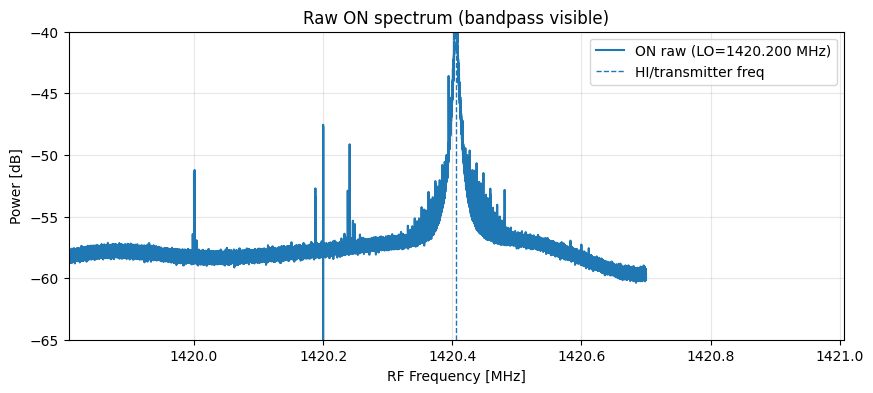

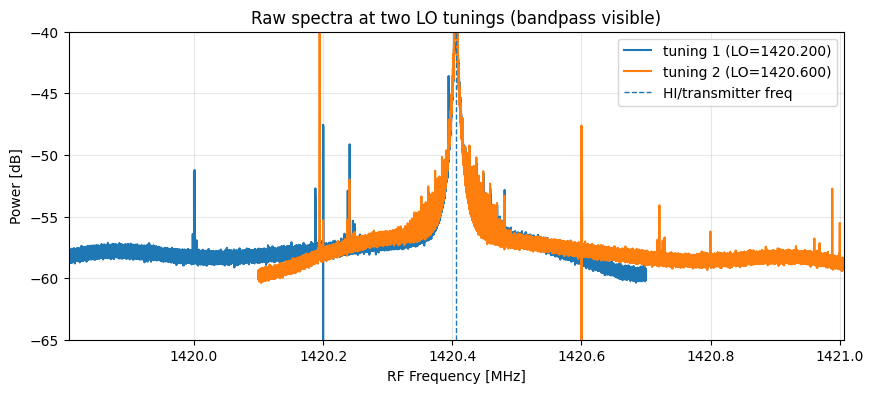

Line baseband in tuning 1: +205.8 kHz
Line baseband in tuning 2: -194.2 kHz


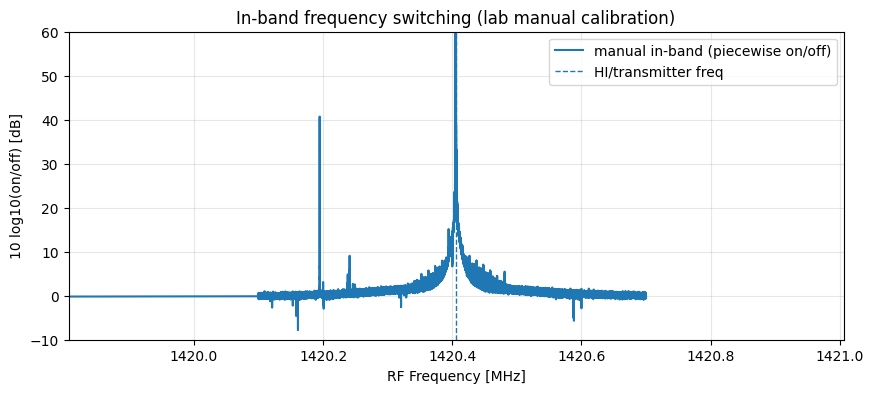

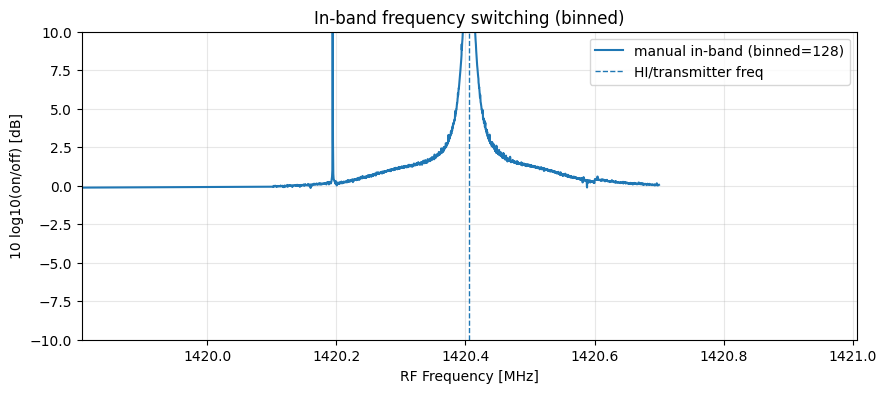

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Inputs (edit these)
# -------------------------
file = "lab2_data/horn_loop_30b_0.2diff_zenith_trans.npz"
fs = 1.0e6                         # Hz
f1 = 1420.2e6                      # tuning 1 (your stored "on_data")
f2 = 1420.6e6                      # tuning 2 (your stored "off_data")
f_hi = 1420.4058e6                 # HI rest / transmitter freq

# -------------------------
# Helpers
# -------------------------
def avg_power(raw, fs):
    raw = raw.astype(np.float32)
    x = raw[..., 0] + 1j*raw[..., 1]
    x = x - x.mean(axis=-1, keepdims=True)     # DC remove per block
    N = x.shape[-1]
    V = np.fft.fft(x, axis=-1) / N
    f = np.fft.fftfreq(N, d=1/fs)
    V = np.fft.fftshift(V, axes=-1)
    f = np.fft.fftshift(f)
    P = np.abs(V)**2
    Pavg = P.mean(axis=tuple(range(P.ndim - 1)))
    return f, Pavg  # baseband Hz, linear power

def rebin_xy(x, y, bin_size=128):
    nb = (len(y) // bin_size) * bin_size
    xb = x[:nb].reshape(-1, bin_size).mean(axis=1)
    yb = y[:nb].reshape(-1, bin_size).mean(axis=1)
    return xb, yb

# -------------------------
# Load
# -------------------------
with np.load(file) as d:
    raw1 = d["on_data"]   # LO = f1
    raw2 = d["off_data"]  # LO = f2

# -------------------------
# Spectra
# -------------------------
fbb, S1 = avg_power(raw1, fs)
fbb2, S2 = avg_power(raw2, fs)
assert np.allclose(fbb, fbb2)

# RF axes for raw plots
frf1 = fbb + f1
frf2 = fbb + f2

S1_dB = 10*np.log10(S1 + 1e-30)
S2_dB = 10*np.log10(S2 + 1e-30)

# -------------------------
# Plot 1: ON-only raw (curvy bandpass)
# -------------------------
plt.figure(figsize=(10,4))
plt.plot(frf1/1e6, S1_dB, label=f"ON raw (LO={f1/1e6:.3f} MHz)")
plt.axvline(f_hi/1e6, ls="--", lw=1, label="HI/transmitter freq")
plt.xlim((f_hi-600e3)/1e6, (f_hi+600e3)/1e6)
plt.ylim(-65, -40)
plt.xlabel("RF Frequency [MHz]")
plt.ylabel("Power [dB]")
plt.title("Raw ON spectrum (bandpass visible)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# -------------------------
# Plot 2: Raw ON and raw OFF overlaid (both curvy)
# -------------------------
plt.figure(figsize=(10,4))
plt.plot(frf1/1e6, S1_dB, label=f"tuning 1 (LO={f1/1e6:.3f})")
plt.plot(frf2/1e6, S2_dB, label=f"tuning 2 (LO={f2/1e6:.3f})")
plt.axvline(f_hi/1e6, ls="--", lw=1, label="HI/transmitter freq")
plt.xlim((f_hi-600e3)/1e6, (f_hi+600e3)/1e6)
plt.ylim(-65, -40)
plt.xlabel("RF Frequency [MHz]")
plt.ylabel("Power [dB]")
plt.title("Raw spectra at two LO tunings (bandpass visible)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# -------------------------
# Manual method (lab): piecewise on/off using upper/lower halves
# -------------------------
fbb_line_1 = f_hi - f1
fbb_line_2 = f_hi - f2
print(f"Line baseband in tuning 1: {fbb_line_1/1e3:+.1f} kHz")
print(f"Line baseband in tuning 2: {fbb_line_2/1e3:+.1f} kHz")

# Identify which spectrum has line in upper vs lower half
if (fbb_line_1 > 0) and (fbb_line_2 < 0):
    Sup, Slow = S1, S2
    f_up, f_low = f1, f2
elif (fbb_line_2 > 0) and (fbb_line_1 < 0):
    Sup, Slow = S2, S1
    f_up, f_low = f2, f1
else:
    print("WARNING: line not on opposite sides for the two tunings; manual swap is not ideal.")
    Sup, Slow = S1, S2
    f_up, f_low = f1, f2

upper = fbb > 0
lower = fbb < 0

cal = np.empty_like(fbb, dtype=np.float64)
cal[upper] = Sup[upper] / (Slow[upper] + 1e-30)
cal[lower] = Slow[lower] / (Sup[lower] + 1e-30)
cal_dB = 10*np.log10(cal + 1e-30)

# RF axis for stitched calibrated spectrum
f_rf = np.empty_like(fbb, dtype=np.float64)
f_rf[upper] = fbb[upper] + f_up
f_rf[lower] = fbb[lower] + f_low

idx = np.argsort(f_rf)

plt.figure(figsize=(10,4))
plt.plot(f_rf[idx]/1e6, cal_dB[idx], label="manual in-band (piecewise on/off)")
plt.axvline(f_hi/1e6, ls="--", lw=1, label="HI/transmitter freq")
plt.xlim((f_hi-600e3)/1e6, (f_hi+600e3)/1e6)
plt.ylim(-10, 60)
plt.xlabel("RF Frequency [MHz]")
plt.ylabel("10 log10(on/off) [dB]")
plt.title("In-band frequency switching (lab manual calibration)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Optional: binned calibrated (useful for weak broad HI)
bin_size = 128
f_b, cal_b = rebin_xy(f_rf[idx], cal_dB[idx], bin_size=bin_size)

plt.figure(figsize=(10,4))
plt.plot(f_b/1e6, cal_b, label=f"manual in-band (binned={bin_size})")
plt.axvline(f_hi/1e6, ls="--", lw=1, label="HI/transmitter freq")
plt.xlim((f_hi-600e3)/1e6, (f_hi+600e3)/1e6)
plt.ylim(-10, 10)
plt.xlabel("RF Frequency [MHz]")
plt.ylabel("10 log10(on/off) [dB]")
plt.title("In-band frequency switching (binned)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Keys in npz: ['on_data', 'off_data']


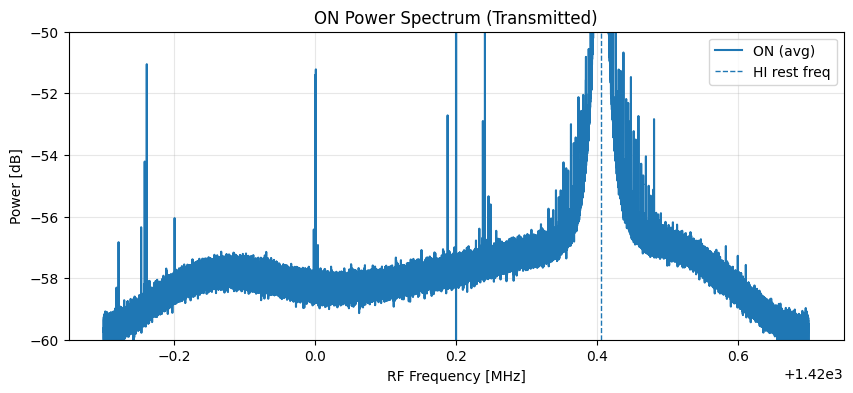

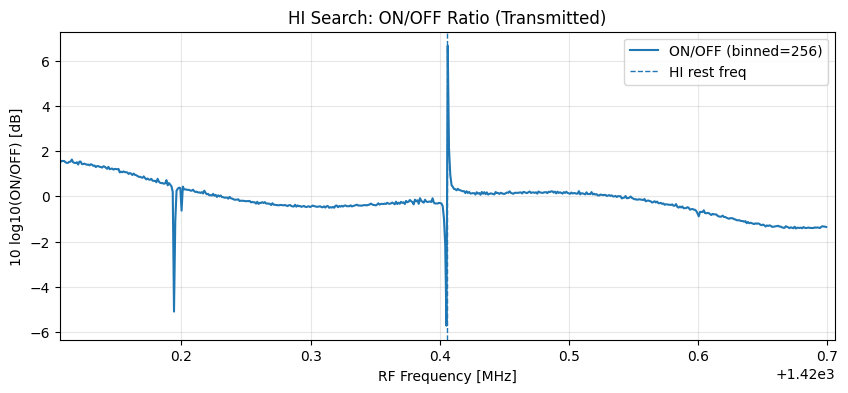

In [23]:
# Power spectra for HI lab file (I/Q, averaged) + ON/OFF ratio in the overlapping RF band

import numpy as np
import matplotlib.pyplot as plt

# ---- File + known capture settings from your table ----
file = "lab2_data/horn_loop_30b_0.2diff_zenith_trans.npz"   # <-- change path if needed
fs   = 1.0e6                                   # Hz
f_on_center  = 1420.2e6                        # Hz (your table: on freq)
f_off_center = 1420.6e6                        # Hz (your table: off freq)
f_hi = 1420.4058e6                             # Hz

# ---- Helpers ----
def avg_power_spectrum_from_raw(raw, fs):
    """
    raw: array with shape (..., NSAMPS, 2) where last axis is [I, Q] int8
    returns: f_base (Hz, fftshifted, increasing), Pavg (linear power, averaged)
    """
    raw = raw.astype(np.float32)

    # Complex I/Q
    x = raw[..., 0] + 1j * raw[..., 1]

    # Remove DC per capture block
    x = x - x.mean(axis=-1, keepdims=True)

    N = x.shape[-1]
    V = np.fft.fft(x, axis=-1) / N
    f = np.fft.fftfreq(N, d=1/fs)

    V = np.fft.fftshift(V, axes=-1)
    f = np.fft.fftshift(f)

    P = np.abs(V)**2
    Pavg = P.mean(axis=tuple(range(P.ndim - 1)))  # average all axes except frequency

    return f, Pavg

def rebin_xy(x, y, bin_size=256):
    nb = (len(y) // bin_size) * bin_size
    xb = x[:nb].reshape(-1, bin_size).mean(axis=1)
    yb = y[:nb].reshape(-1, bin_size).mean(axis=1)
    return xb, yb

# ---- Load file robustly ----
with np.load(file) as d:
    keys = list(d.keys())
    print("Keys in npz:", keys)

    # Try common key names
    if "on_data" in d and "off_data" in d:
        raw_on  = d["on_data"]
        raw_off = d["off_data"]
    elif "data_on" in d and "data_off" in d:
        raw_on  = d["data_on"]
        raw_off = d["data_off"]
    elif "arr_0" in d:
        # If the file is just one dataset, treat it as "on"
        raw_on  = d["arr_0"]
        raw_off = None
    else:
        raise KeyError("Could not find on/off datasets in the npz. Keys shown above.")

# ---- Compute averaged spectra ----
f_base_on,  Pon  = avg_power_spectrum_from_raw(raw_on, fs)
f_rf_on = f_base_on + f_on_center

# Plot ON-only spectrum near HI
PdB_on = 10*np.log10(Pon + 1e-30)
plt.figure(figsize=(10,4))
plt.plot(f_rf_on/1e6, PdB_on, label="ON (avg)")
plt.axvline(f_hi/1e6, linestyle="--", linewidth=1, label="HI rest freq")
# plt.xlim((f_hi-300e3)/1e6, (f_hi+300e3)/1e6)
plt.ylim(-60, -50)
plt.xlabel("RF Frequency [MHz]")
plt.ylabel("Power [dB]")
plt.title("ON Power Spectrum (Transmitted)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ---- If OFF exists, do ON/OFF ratio in overlapping RF region (best for seeing HI) ----
if raw_off is not None:
    f_base_off, Poff = avg_power_spectrum_from_raw(raw_off, fs)
    f_rf_off = f_base_off + f_off_center

    # Determine overlap in RF
    lo = max(f_rf_on.min(), f_rf_off.min())
    hi = min(f_rf_on.max(), f_rf_off.max())
    m = (f_rf_on >= lo) & (f_rf_on <= hi)

    # Interpolate OFF power onto ON RF grid in overlap
    # (np.interp requires increasing x; fftshifted f_rf arrays are increasing)
    Poff_interp = np.interp(f_rf_on[m], f_rf_off, Poff)

    ratio = Pon[m] / (Poff_interp + 1e-30)
    ratio_dB = 10*np.log10(ratio + 1e-30)

    # Re-bin to make broad HI features visible
    bin_size = 256
    f_rb, r_db_binned = rebin_xy(f_rf_on[m], ratio_dB, bin_size=bin_size)

    plt.figure(figsize=(10,4))
    plt.plot(f_rb/1e6, r_db_binned, label=f"ON/OFF (binned={bin_size})")
    plt.axvline(f_hi/1e6, linestyle="--", linewidth=1, label="HI rest freq")
    plt.xlim((f_hi-300e3)/1e6, (f_hi+300e3)/1e6)
    # plt.ylim(-0.5, 0.5)  # adjust as needed once you see scale
    plt.xlabel("RF Frequency [MHz]")
    plt.ylabel("10 log10(ON/OFF) [dB]")
    plt.title("HI Search: ON/OFF Ratio (Transmitted)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("No OFF dataset found in this file; only ON spectrum was plotted.")

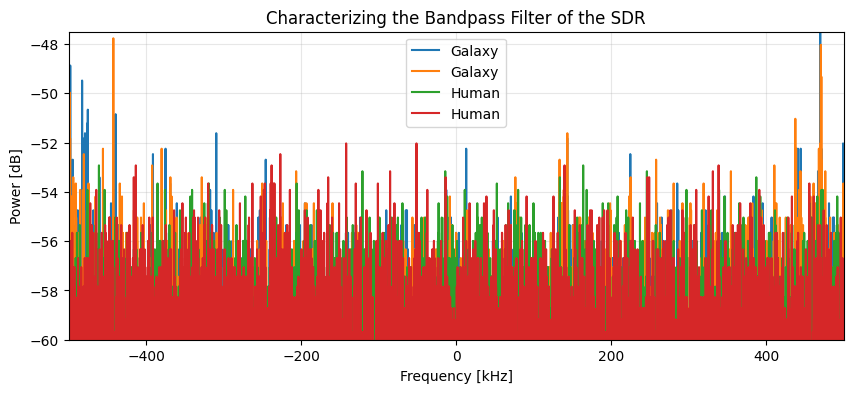

In [19]:
# Multiple Power Spectrum Create

fs = 1e6
files = [
    ("Galaxy",  "lab2_data/horn_galaxy.npz"),
    ("Human",  "lab2_data/horn_human2.npz"),
    # ("Anti-aliasing Filter ON (400 kHz)", "sdr_bp/Z0_400_kHz_bp.npz"),
]

plt.figure(figsize=(10,4))

for label, fn in files:
    arr = func.load_file(fn)
    x = arr[1].astype(float)
    N = len(x)

    V = np.fft.fft(x)/N
    f = np.fft.fftfreq(N, d=1/fs)

    V = np.fft.fftshift(V)
    f = np.fft.fftshift(f)

    P = np.abs(V)**2
    PdB = 10*np.log10(P + 1e-30)

    plt.plot((f)/1e3, PdB, label=label)

plt.xlim(-500, 500)
plt.ylim(-60, -47.5)
plt.xlabel("Frequency [kHz]")
plt.ylabel("Power [dB]")
plt.title("Characterizing the Bandpass Filter of the SDR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()